In [1]:
import numpy as np
import tensorflow as tf
import math, os, sys, datetime

C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
dataset = np.load('dataset/all_data-preprocessed.npz')
features, labels = dataset['features'].astype('float32'), dataset['labels'].astype('float32')
train_test_split_factor = .8
validation_split_factor = .2
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=1), np.expand_dims(test_x, axis=1) # for use with TimeDistributed
input_shape = train_x.shape
#train_x, test_x = train_x.reshape((1, -1)), test_x.reshape((1, -1))
#train_y, test_y = np.expand_dims(train_y, axis=1), np.expand_dims(test_y, axis=1) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(288, 1, 1, 7) (288, 7) (72, 1, 1, 7) (72, 7)


In [4]:
class endCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") >= .99 or logs.get("val_accuracy") > .95:
            print('\nAccuracy reach the satification point, Stop Training.')
            self.model.stop_training = True
            try:
                print('\nSaving the model')
                if os.path.isdir('./model_out') == False:
                    os.path.mkdir('./model_out')
                self.model.save(f'./model_out/model-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
            except Exception as e:
                print(f'Error : {e}')

In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ckp_path = './save_ckp/checkpoints'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
    save_weights_only=True
)
layers = [
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='linear')
]
model = tf.keras.models.Sequential(layers=layers)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy', tf.keras.metrics.MeanSquaredError()])
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
#model.summary()

In [6]:
graph = model.fit(train_x, train_y, validation_split=validation_split_factor, epochs=250, callbacks=[tensorboard_callback, checkpoint_callback, endCallback()])
model.summary()

Epoch 1/250
1/8 [==>...........................] - ETA: 0s - loss: 1081074.0000 - accuracy: 0.1250WARNING:tensorflow:From C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - 1s 135ms/step - loss: 1063893.0000 - accuracy: 0.1609 - val_loss: 69016.3125 - val_accuracy: 0.1379
Epoch 2/250
8/8 [==============================] - 0s 47ms/step - loss: 1063824.5000 - accuracy: 0.1609 - val_loss: 68997.7734 - val_accuracy: 0.1379
Epoch 3/250
8/8 [==============================] - 0s 44ms/step - loss: 1063722.6250 - accuracy: 0.1609 - val_loss: 68969.0703 - val_accuracy: 0.1379
Epoch 4/250
8/8 [==============================] - 0s 40ms/step - loss: 1063566.2500 - accuracy: 0.1609 - val_loss: 68922.9922 - val_accuracy: 0.1379
Epoch 5/250
8/8 [======

In [7]:
model.load_weights(ckp_path)
model.evaluate(test_x, test_y)

3/3 [==============================] - 0s 14ms/step - loss: 413.2155 - accuracy: 0.3889


[413.2155456542969, 0.3888888955116272]

In [8]:
model.save('./weights/tdnn.h5')

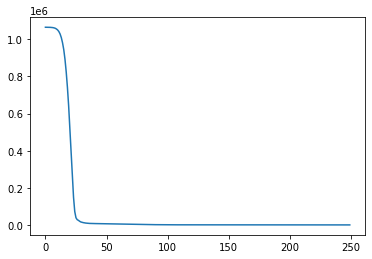

In [9]:
import matplotlib.pyplot as plt
loss = graph.history['loss']
val_loss = graph.history['val_loss']
val_acc = graph.history['val_accuracy']
plt.plot(range(len(loss)), loss)

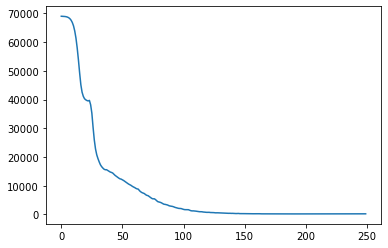

In [10]:
plt.plot(range(len(val_loss)), val_loss)

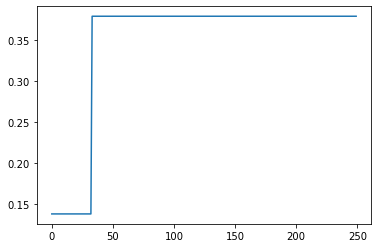

In [11]:
plt.plot(range(len(val_acc)), val_acc)

In [12]:
pred = model.predict(test_x)

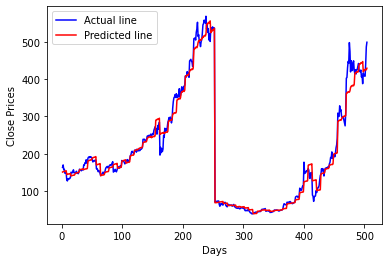

In [13]:
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

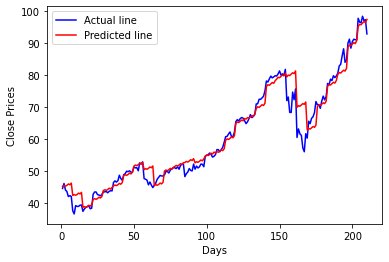

In [14]:
pred = model.predict(train_x[:30, :, :, :])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(train_y[:30, :], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

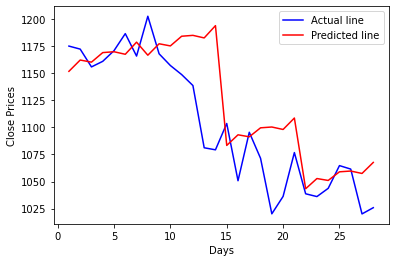

In [15]:
import matplotlib.pyplot as plt
test_dataset = np.load('dataset/GOOG-preprocessed.npz')
test_stock_x, test_stock_y = test_dataset['features'], test_dataset['labels']
test_stock_x = np.expand_dims(test_stock_x, axis=1)
pred = model.predict(test_stock_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_stock_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

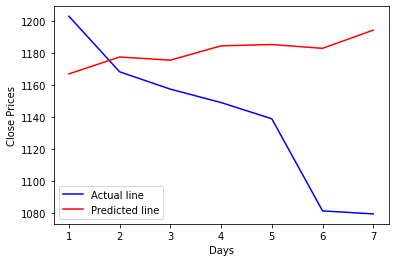

In [16]:
test_dataset = np.load('dataset/GOOG-preprocessed.npz')
test_stock_x, test_stock_y = test_dataset['features'][1], test_dataset['labels'][1, :]
test_stock_x = np.expand_dims(test_stock_x, axis=0)
test_stock_x = np.expand_dims(test_stock_x, axis=0)
test_stock_y = np.expand_dims(test_stock_y, axis=0)
pred = model.predict(test_stock_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_stock_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()